# Make signature sub-networks using the `CD_center_LM` signatures 

In [1]:
import os, sys, json
from collections import Counter
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial import distance as dist
from sklearn import neighbors
from pymongo import MongoClient

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
from graph_utils import *

<IPython.core.display.Javascript object>

In [3]:
## Load signature metadata mongodb
client = MongoClient('mongodb://146.203.54.131:27017/')
coll = client['L1000FWD']['sigs']
cur = coll.find({'SCS_centered_by_batch': {'$lt': 0.05}},  
                {'_id':False, 
                 'sig_id':True, 
                 'SCS_centered_by_batch':True,
                 'pert_id':True,
                 'cell_id':True,
                 'pert_dose':True,
                 'pert_time':True,
                })

sig_meta_df = pd.DataFrame([doc for doc in cur]).set_index('sig_id')
sig_meta_df.rename(index=str,columns={'SCS_centered_by_batch':'pvalue'}, inplace=True)
print sig_meta_df.shape
sig_meta_df.head()

(48098, 5)


,pvalue,cell_id,pert_dose,pert_id,pert_time
sig_id,,,,,
LJP001_HS578T_24H:BRD-K52911425-001-04-9:2,0.0028,HS578T,2.0,BRD-K52911425,24.0
LJP001_HS578T_24H:BRD-K69932463-001-05-6:10,0.0483,HS578T,10.0,BRD-K69932463,24.0
LJP001_HS578T_24H:BRD-K85606544-001-04-2:10,0.0007,HS578T,10.0,BRD-K85606544,24.0
LJP001_HS578T_24H:BRD-K72636697-001-01-5:10,0.0000,HS578T,10.0,BRD-K72636697,24.0
LJP001_HS578T_24H:BRD-K13390322-001-02-2:0.4,0.0000,HS578T,0.4,BRD-K13390322,24.0


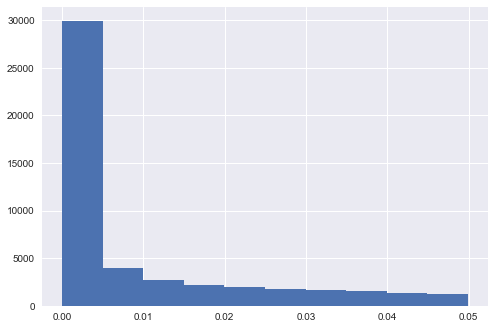

In [4]:
plt.hist(sig_meta_df['pvalue']);

In [5]:
def retrieve_sig_mat(sig_ids, coll, key):
    '''Retrieve signatures matrix from MongoDB'''
    # Retrieve signature matrix
    sig_mat = np.zeros((len(sig_ids), 978))
    for i, sig_id in enumerate(sig_ids): 
        doc = coll.find_one({'sig_id': sig_id}, {'_id':False, key:True})
        sig_mat[i] = doc[key]
        if i % 5000 == 0:
            print i, len(sig_ids)
    return sig_mat

In [6]:
## Extract signature matrix
mat = retrieve_sig_mat(sig_meta_df.index, coll, 'CD_center_LM')
print mat.shape

0 48098
5000 48098
10000 48098
15000 48098
20000 48098
25000 48098
30000 48098
35000 48098
40000 48098
45000 48098
(48098, 978)


In [23]:
# # Report G_new stats
# sig_meta_df_sub = sig_meta_df.loc[list(G_new.nodes())]
# print sig_meta_df_sub.shape
# print 'Unique pert_ids:', sig_meta_df_sub['pert_id'].nunique()
# print 'Unique cell lines:', sig_meta_df_sub['cell_id'].nunique()

(16848, 4)
Unique pert_ids: 3237
Unique cell lines: 68


In [24]:
# nx.write_gml(G_new, 'Signature_Graph_CD_center_LM_sig-only_%dnodes.gml' % G_new.number_of_nodes())

# Create network of signatures for each cell types

In [7]:
sig_counts_for_cells = sig_meta_df.reset_index().groupby('cell_id')['sig_id'].count().sort_values(ascending=False)
sig_counts_for_cells[:20]


cell_id
MCF7        6965
VCAP        5856
PC3         5638
A549        4115
A375        3086
HA1E        3005
HT29        2717
HCC515      2504
HEPG2       1861
NPC          973
SKB          868
ASC          777
BT20         571
MDAMB231     545
SKBR3        541
PHH          505
MCF10A       471
HS578T       454
NEU          378
THP1         229
Name: sig_id, dtype: int64

In [8]:
!mkdir -p graphs_for_cells

In [11]:
# Collection to store graph visualizations
coll_graphs = client['L1000FWD']['graphs']
coll_graphs.drop()
coll_graphs.create_index('name', unique=True)

u'name_1'

In [12]:
for cell in sig_counts_for_cells[:20].index:
    mask_cell = np.in1d(sig_meta_df['cell_id'], [cell])
    mat_cell = mat[mask_cell,]
    sig_meta_df_sub = sig_meta_df.loc[mask_cell]
    print mat_cell.shape
    
    # Firework pipeline
#     adj_mat = compute_adjcency_mat(mat_cell)
#     G = create_graph_by_threshold(adj_mat, 99.9)
#     G = filter_out_small_ccs(G, cutoff=5)
#     print G.number_of_nodes(), G.number_of_edges()
    # kNN
    G = create_knn_graph(mat_cell, k=5, metric='cosine')
    print G.number_of_nodes(), G.number_of_edges()
    
    coords, node_ids = network_layout(G)

    layout_doc = {
        'sig_ids': [sig_meta_df_sub.index[i] for i in node_ids],
        'x': coords[:, 0].tolist(),
        'y': coords[:, 1].tolist(),
        'name': '%s_kNN_5' % cell,
        'coll': 'sigs',
    }
    
    coll_graphs.insert_one(layout_doc)
    
    ## tSNE
#     dist_mat = pairwise_distances(mat_cell, metric='cosine')
#     print dist_mat.shape
#     tsne = manifold.TSNE(metric='precomputed', verbose=10)
#     coords = tsne.fit_transform(dist_mat)
    
#     print coords.shape

#     sig_ids = sig_meta_df_sub.index
    
#     # create a data frame for the graph
#     G_df = pd.DataFrame({'sig_id': sig_ids, 'x': coords[:,0], 'y': coords[:,1]}).set_index('sig_id')
    
#     G_df.to_csv('graphs_for_cells/%s-tSNE_layout.csv' % cell)


(6965, 978)
6965 29422
(5856, 978)
5856 24419
(5638, 978)
5638 23469
(4115, 978)
4115 16933
(3086, 978)
3086 12627
(3005, 978)
3005 12179
(2717, 978)
2717 11170
(2504, 978)
2504 10201
(1861, 978)
1861 7407
(973, 978)
973 3804
(868, 978)
868 3376
(777, 978)
777 2993
(571, 978)
571 2068
(545, 978)
545 2047
(541, 978)
541 1954
(505, 978)
505 1898
(471, 978)
471 1728
(454, 978)
454 1666
(378, 978)
378 1426
(229, 978)
229 764


In [18]:
cy = CyRestClient(ip=IP, port=PORT)
# Reset session
cy.session.delete()
# POST the graph to CyREST
G_cy = cy.network.create_from_networkx(G)

# Change the layout params
layout_parameters = [
    {"name": "numIterations", "value": 100}, 
    {"name":"numIterationsEdgeRepulsive", "value":10}
]
resp = requests.put(BASE_URL+ '/apply/layouts/force-directed-cl/parameters', 
             data=json.dumps(layout_parameters),
             headers=HEADERS)
cy.layout.apply(name='force-directed-cl', network=G_cy)



In [19]:
layout_parameters = [
    {"name": "maxIterations", "value": 2000}, 
    {"name":"randomize", "value":True},
]
resp = requests.put(BASE_URL+ '/apply/layouts/allegro-edge-repulsive-strong-clustering/parameters', 
             data=json.dumps(layout_parameters),
             headers=HEADERS)
cy.layout.apply(name='allegro-edge-repulsive-strong-clustering', network=G_cy)
import time
# time.sleep(5)
# Get current view
view = G_cy.get_first_view()


In [13]:
print BASE_URL+ '/apply/layouts/allegro-edge-repulsive-strong-clustering/parameters'

http://127.0.0.1:1234/v1/apply/layouts/allegro-edge-repulsive-strong-clustering/parameters


In [10]:
cy = CyRestClient(ip=IP, port=PORT)
# Reset session
cy.session.delete()
# POST the graph to CyREST
G_cy = cy.network.create_from_networkx(G)

# Change the layout params
layout_parameters = [
    {"name": "numIterations", "value": 10}, 
    {"name":"numIterationsEdgeRepulsive", "value":10}
]
resp = requests.put(BASE_URL+ '/apply/layouts/force-directed-cl/parameters', 
             data=json.dumps(layout_parameters),
             headers=HEADERS)
cy.layout.apply(name='force-directed-cl', network=G_cy)


layout_parameters = [
    {"name": "maxIterations", "value": 10000}, 
    {"name":"randomize", "value":True},
]
resp = requests.put(BASE_URL+ '/apply/layouts/allegro-edge-repulsive-strong-clustering/parameters', 
             data=json.dumps(layout_parameters),
             headers=HEADERS)
cy.layout.apply(name='allegro-edge-repulsive-strong-clustering', network=G_cy)
# Get current view
view = G_cy.get_first_view()
nodes = view['elements']['nodes']
# Get a coord matrix ordered by id_original
ids_original = np.array([n['data']['id_original'] for n in nodes]).astype(np.int32)
xs = [n['position']['x'] for n in nodes]
ys = [n['position']['y'] for n in nodes]
coords = np.array([xs, ys]).T


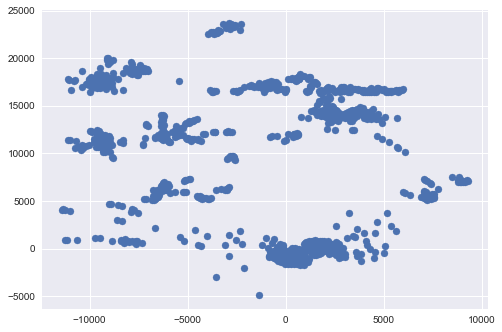

In [16]:
plt.scatter(coords[:, 0], coords[:, 1])

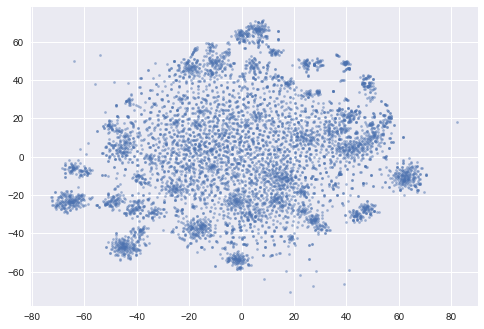

In [29]:
plt.scatter(coords[:, 0], coords[:, 1], s=5, alpha=0.5)

# Aggregated signatures

## pert_id x cell
## pert_id


In [33]:
sig_meta_df.groupby(['pert_id', 'cell_id'])['pvalue'].count()

pert_id        cell_id
BRD-A00100033  PHH        1
BRD-A00267231  A549       1
               ASC        1
               HA1E       1
               PC3        1
BRD-A00420644  A375       1
               A549       2
               HA1E       1
               HCC515     1
               HEPG2      1
               HT29       1
               MCF7       2
               PC3        1
               VCAP       1
BRD-A00474148  HA1E       1
               PC3        1
               VCAP       2
BRD-A00520476  HA1E       1
               HT29       1
BRD-A00546892  A375       1
               ASC        1
               NPC        1
BRD-A00626522  PC3        1
BRD-A00758722  ASC        1
               MCF7       1
               VCAP       2
BRD-A00993607  A375       1
               A549       1
               HA1E       1
               MCF7       2
                         ..
BRD-U88459701  PHH        3
               PL21       1
               SW948      1
               VCAP      

In [34]:
sig_meta_df.groupby(['pert_id'])['pvalue'].count()

pert_id
BRD-A00100033     1
BRD-A00267231     4
BRD-A00420644    11
BRD-A00474148     4
BRD-A00520476     2
BRD-A00546892     3
BRD-A00626522     1
BRD-A00758722     4
BRD-A00993607     6
BRD-A01145011    15
BRD-A01295252     3
BRD-A01317026     3
BRD-A01320529    12
BRD-A01346607    10
BRD-A01593789     9
BRD-A01643550    10
BRD-A01787639     5
BRD-A01826957     2
BRD-A01960364     5
BRD-A01973626     1
BRD-A01999384     3
BRD-A02006392    16
BRD-A02176148     5
BRD-A02180903    10
BRD-A02198599     3
BRD-A02333338     6
BRD-A02367930     3
BRD-A02481876    59
BRD-A02710418     1
BRD-A02713983     3
                 ..
BRD-U01690642     5
BRD-U04166717    15
BRD-U06594984     1
BRD-U08759356    12
BRD-U25771771    13
BRD-U29336476    14
BRD-U31801276    11
BRD-U32049204     1
BRD-U32365159    11
BRD-U33728988    18
BRD-U37049823    13
BRD-U43867373    14
BRD-U44618005     9
BRD-U44700465    15
BRD-U51951544    16
BRD-U64289953    16
BRD-U66370498     5
BRD-U68942961    12
BRD-U7323881

In [19]:
coll_pert_cell = client['L1000FWD']['sigs_pert_cell']
coll_pert_cell.create_index('sig_id', unique=True)

u'sig_id_1'

In [8]:
sig_meta_df.head()

,pvalue,cell_id,pert_dose,pert_id,pert_time
sig_id,,,,,
LJP001_HS578T_24H:BRD-K52911425-001-04-9:2,0.0028,HS578T,2.0,BRD-K52911425,24.0
LJP001_HS578T_24H:BRD-K69932463-001-05-6:10,0.0483,HS578T,10.0,BRD-K69932463,24.0
LJP001_HS578T_24H:BRD-K85606544-001-04-2:10,0.0007,HS578T,10.0,BRD-K85606544,24.0
LJP001_HS578T_24H:BRD-K72636697-001-01-5:10,0.0000,HS578T,10.0,BRD-K72636697,24.0
LJP001_HS578T_24H:BRD-K13390322-001-02-2:0.4,0.0000,HS578T,0.4,BRD-K13390322,24.0


In [16]:
coll_pert_cell.drop()

In [17]:
c = 0
for (pert_id, cell_id), sig_meta_df_sub in sig_meta_df.groupby(['pert_id', 'cell_id']):
    sig_ids = sig_meta_df_sub.index
    mask = np.in1d(sig_meta_df.index, sig_ids)
#     print mat[mask].shape
    agg_sig = mat[mask].mean(axis=0)
    mean_cosine_dist = dist.squareform(pairwise_distances(mat[mask], metric='cosine')).mean()
    
    id_ = '%s:%s' % (pert_id, cell_id)
    doc = {
        'sig_id': id_,
        'CD_center_LM': agg_sig.tolist(),
        'mean_cosine_dist': mean_cosine_dist,
        'sig_ids': sig_ids.tolist(),
        'pert_id': pert_id,
        'cell_id': cell_id,
        'avg_dose': sig_meta_df_sub['pert_dose'].mean(),
        'avg_time': sig_meta_df_sub['pert_time'].mean(),
        'avg_pvalue': sig_meta_df_sub['pvalue'].mean(),
        'n_signatures_aggregated': len(sig_ids)
    }
#     print agg_sig.shape
    
    coll_pert_cell.insert_one(doc)
    c += 1
    
    if c % 1000 == 0:
        print c
#     break

/Library/Python/2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: Mean of empty slice.


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [20]:
coll_pert = client['L1000FWD']['sigs_pert']
coll_pert.create_index('sig_id', unique=True)

u'sig_id_1'

In [26]:
c = 0 
for pert_id, sig_meta_df_sub in sig_meta_df.groupby(['pert_id']):
    sig_ids = sig_meta_df_sub.index
    mask = np.in1d(sig_meta_df.index, sig_ids)

#     agg_sig = mat[mask].mean(axis=0)
#     print len(sig_ids)
    
    docs = []
    for cell_id in sig_meta_df_sub['cell_id'].unique():
        id_ = '%s:%s' % (pert_id, cell_id)
        doc = coll_pert_cell.find_one({'sig_id':id_})
        docs.append(doc)
    
    sig_mat = np.array([doc['CD_center_LM'] for doc in docs])
#     print sig_mat.shape
    agg_sig = sig_mat.mean(axis=0)
#     print agg_sig.shape
    mean_cosine_dist = dist.squareform(pairwise_distances(sig_mat, metric='cosine')).mean()
    
    
    pert_doc = {
        'sig_id': pert_id,
        'CD_center_LM': agg_sig.tolist(),
        'mean_cosine_dist': mean_cosine_dist,
        'sig_ids': sig_ids.tolist(),
        'cell_ids': sig_meta_df_sub['cell_id'].unique().tolist(),
        'avg_dose': sig_meta_df_sub['pert_dose'].mean(),
        'avg_time': sig_meta_df_sub['pert_time'].mean(),
        'avg_pvalue': sig_meta_df_sub['pvalue'].mean(),
        'n_signatures_aggregated': len(sig_ids),
        'n_cells': sig_meta_df_sub['cell_id'].nunique(),
    }    
    
    coll_pert.insert_one(pert_doc)
    c += 1
    if c % 500 ==0:
        print c,

/Library/Python/2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: Mean of empty slice.


500 1000 1500 2000 2500 3000 3500 4000 4500


# Create Firework layout for aggregated networks


In [48]:
# Collection to store graph visualizations
coll_graphs = client['L1000FWD']['graphs']
coll_graphs.create_index('name', unique=True)

u'name_1'

In [27]:
# Create Firework layout for aggregated networks
n_perts = coll_pert.count()
pert_ids = coll_pert.distinct('sig_id')

mat = np.zeros((n_perts, 978))
for i, pert_id in enumerate(pert_ids):
    doc = coll_pert.find_one({'sig_id': pert_id})
    mat[i] = doc['CD_center_LM']

print mat.shape

adj_mat = compute_adjcency_mat(mat)


(4944, 978)


In [41]:
# Create and layout graph by kNN
G = create_knn_graph(mat, k=5, metric='cosine')
print G.number_of_nodes(), G.number_of_edges()
coords, ids_original = network_layout(G)
print coords.shape, len(ids_original)
print ids_original[:5]

4944 21674
(4944, 2) 4944
[4943 4942 4941 4940 4939]


In [42]:
knn_layout = {
    'sig_ids': [pert_ids[id_ori] for id_ori in ids_original],
    'x': coords[:, 0].tolist(),
    'y': coords[:, 1].tolist(),
    'name': 'kNN_5_layout',
    'coll': 'sigs_pert',
}

coll_graphs.insert_one(knn_layout)

In [46]:
# Create and layout graph by threshold
G = create_graph_by_threshold(adj_mat, 99.5)
print G.number_of_nodes(), G.number_of_edges()
G = filter_out_small_ccs(G, cutoff=4)
print G.number_of_nodes(), G.number_of_edges()
coords, ids_original = network_layout(G)

0.323172396398
4944 61096
1934 61073


In [47]:
thres_layout = {
    'sig_ids': [pert_ids[id_ori] for id_ori in ids_original],
    'x': coords[:, 0].tolist(),
    'y': coords[:, 1].tolist(),
    'name': 'threshold_99.5',
    'coll': 'sigs_pert',
}

coll_graphs.insert_one(thres_layout)

In [52]:
# Create Firework layout for aggregated networks
n_sigs = coll_pert_cell.count()
sig_ids = coll_pert_cell.distinct('sig_id')

mat = np.zeros((n_sigs, 978))
for i, sig_id in enumerate(sig_ids):
    doc = coll_pert_cell.find_one({'sig_id': sig_id})
    mat[i] = doc['CD_center_LM']

print mat.shape

adj_mat = compute_adjcency_mat(mat)


(29847, 978)


In [53]:
# Create and layout graph by threshold
G = create_graph_by_threshold(adj_mat, 99.9)
print G.number_of_nodes(), G.number_of_edges()
G = filter_out_small_ccs(G, cutoff=4)
print G.number_of_nodes(), G.number_of_edges()
# coords, ids_original = network_layout(G)

0.320732915552
29847 445407
12894 444974


In [56]:
# Relabel nodes with sig_ids
d_id_sig_id = dict(zip(range(len(sig_ids)), sig_ids))
d_id_sig_id = {nid: sig_id for nid, sig_id in d_id_sig_id.items() if G.has_node(nid)}
nx.relabel_nodes(G, d_id_sig_id, copy=False)
print G.nodes()[:5]

[u'BRD-A26595446:MCF7', u'BRD-U37049823:HT29', u'BRD-K31491153:PHH', u'BRD-K03816923:A549', u'BRD-K43620258:SW620']


In [57]:
nx.write_gml(G, 'graph_pert_cell_%dnodes_99.9.gml' % G.number_of_nodes())

In [54]:
coords, ids_original = network_layout(G)

ValueError: No JSON object could be decoded